# GAT Implementation

```
@article{
  velickovic2018graph,
  title="{Graph Attention Networks}",
  author={Veli{\v{c}}kovi{\'{c}}, Petar and Cucurull, Guillem and Casanova, Arantxa and Romero, Adriana and Li{\`{o}}, Pietro and Bengio, Yoshua},
  journal={International Conference on Learning Representations},
  year={2018},
  url={https://openreview.net/forum?id=rJXMpikCZ},
  note={accepted as poster},
}
```

## Import Library

In [25]:
import dgl
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import conv as dgl_conv
from utils.startup_data_set import COMP4222Dataset_hetero
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cpu')

### Hypermeters

In [91]:
val_ratio = 0.1
test_ratio = 0.1

n_hidden = 256
feat_drop = 0.2
att_drop = 0.2
negative_slope = 0.2
heads = [2, 2, 2]
residual = True

lr = 0.01
early_stopping = 10
ep = 300

## Load Dataset

In [39]:
import numpy as np
np.random.seed(0)

In [40]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [41]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [42]:
from utils.CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [43]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [94]:
class GATModel(nn.Module):
    def __init__(self, in_size, hid_size, out_size, heads):
        super().__init__()
        self.gat_layers = nn.ModuleList()
        # three-layer GAT
        self.gat_layers.append(dgl_conv.GATConv(in_size, hid_size, heads[0], activation=F.elu))
        self.gat_layers.append(dgl_conv.GATConv(hid_size*heads[0], hid_size, heads[1], feat_drop=feat_drop, attn_drop=att_drop, residual=residual, activation=F.elu))
        self.gat_layers.append(dgl_conv.GATConv(hid_size*heads[1], out_size, heads[2], feat_drop=feat_drop, attn_drop=att_drop, residual=residual, activation=None))

    def forward(self, g, inputs):
        h = inputs
        for i, layer in enumerate(self.gat_layers):
            h = layer(g, h)
            if i == 2:  # last layer 
                h = h.mean(1)
            else:       # other layer(s)
                h = h.flatten(1)
        return h

In [95]:
gat_model = GATModel(
    in_feats, 
    n_hidden, 
    2,
    heads
    )

pred = DotPredictor()

### Training Loop

In [96]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gat_model.parameters(), pred.parameters()), lr=lr)

for e in range(ep):
    # forward
    h = gat_model(train_g, train_g.ndata['feat'].float())
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break

Epoch: 0 	 Train loss: 0.678 	 Val loss: 0.689 	 Train AUC: 0.671 	 Val AUC: 0.565
Epoch: 10 	 Train loss: 0.941 	 Val loss: 1.116 	 Train AUC: 0.748 	 Val AUC: 0.64
Epoch: 20 	 Train loss: 0.963 	 Val loss: 1.01 	 Train AUC: 0.678 	 Val AUC: 0.629
Epoch: 30 	 Train loss: 0.644 	 Val loss: 0.664 	 Train AUC: 0.75 	 Val AUC: 0.728
Epoch: 40 	 Train loss: 0.579 	 Val loss: 0.626 	 Train AUC: 0.773 	 Val AUC: 0.726
Epoch: 50 	 Train loss: 0.567 	 Val loss: 0.611 	 Train AUC: 0.782 	 Val AUC: 0.734
Epoch: 60 	 Train loss: 0.548 	 Val loss: 0.597 	 Train AUC: 0.823 	 Val AUC: 0.773
Epoch: 70 	 Train loss: 0.526 	 Val loss: 0.603 	 Train AUC: 0.85 	 Val AUC: 0.774
Epoch: 80 	 Train loss: 0.517 	 Val loss: 0.595 	 Train AUC: 0.849 	 Val AUC: 0.773
Epoch: 90 	 Train loss: 0.507 	 Val loss: 0.574 	 Train AUC: 0.856 	 Val AUC: 0.783
Epoch: 100 	 Train loss: 0.501 	 Val loss: 0.571 	 Train AUC: 0.859 	 Val AUC: 0.791
Epoch: 110 	 Train loss: 0.496 	 Val loss: 0.563 	 Train AUC: 0.858 	 Val AUC: 0

In [97]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.8034803163045043


### Result Plotting

Text(0, 0.5, 'Loss')

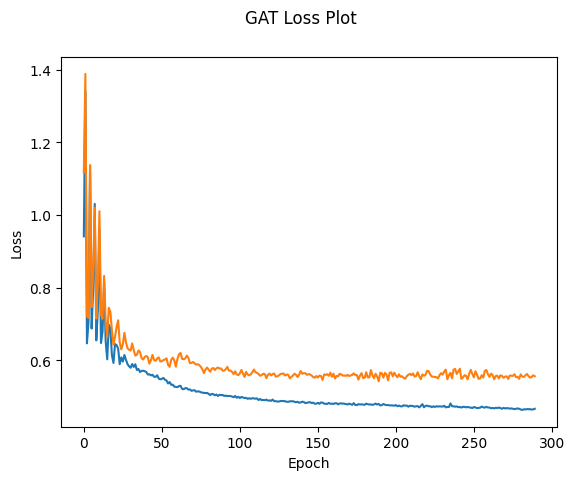

In [99]:
fig = plt.figure()
plt.plot(train_loss[10:], label='training loss')
plt.plot(val_loss[10:], label = 'validation loss')
fig.suptitle('GAT Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

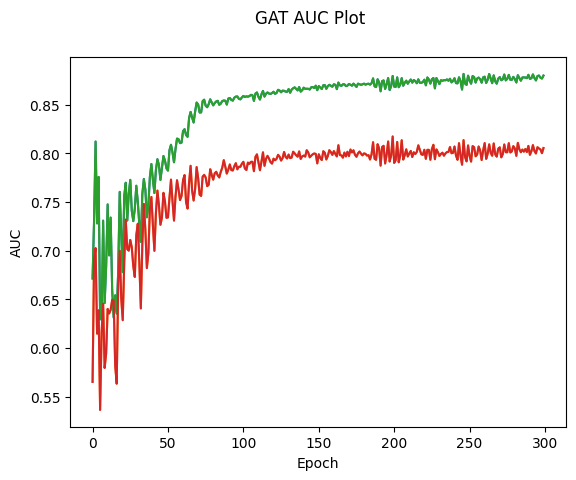

In [100]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('GAT AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.plot(train_AUC)
plt.plot(val_AUC)